In [7]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

In [2]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    shape_num = len(xc)//shape_size
    xc = np.reshape(xc, (shape_num, shape_size))
    yc = np.reshape(yc, (shape_num, shape_size))
    
    for j in range(shape_num):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    p_u, p_d = 0, 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.4 >=SP[i][j]:
            p_d += 1
        if SP[i][j - 1] <= 0.4 <=SP[i][j]:
            p_u += 1
    if p_d == p_u and p_d == 4:
        
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	21
Batch 3 has 	18
Batch 4 has 	51
Batch 5 has 	15
Batch 6 has 	42
Batch 7 has 	42
Batch 8 has 	120
Batch 9 has 	15
Batch 10 has 	42
Batch 11 has 	42
Batch 12 has 	120
Batch 13 has 	39
Batch 14 has 	111
Batch 15 has 	111
Batch 16 has 	318
Batch 17 has 	15
Batch 18 has 	42
Batch 19 has 	42
Batch 20 has 	120
Batch 21 has 	39
Batch 22 has 	111
Batch 23 has 	111
Batch 24 has 	106
Batch 25 has 	39
Batch 26 has 	111
Batch 27 has 	111
Batch 28 has 	318
Batch 29 has 	105
Batch 30 has 	300
Batch 31 has 	300
Batch 32 has 	861
Batch 33 has 	15
Batch 34 has 	38
Batch 35 has 	42
Batch 36 has 	118
Batch 37 has 	39
Batch 38 has 	105
Batch 39 has 	105
Batch 40 has 	310
Batch 41 has 	37
Batch 42 has 	106
Batch 43 has 	105
Batch 44 has 	318
Batch 45 has 	101
Batch 46 has 	250
Batch 47 has 	298
Batch 48 has 	836
Batch 49 has 	36
Batch 50 has 	101
Batch 51 has 	105
Batch 52 has 	316
Batch 53 has 	105
Batch 54 has 	300
Batch 55 has 	301
Batch 56 has 	842
Batch 57 has 	103
Batch 58 has 	294
Bat

In [3]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 433 samples, validate on 109 samples
Epoch 1/1000
 - 3s - loss: 0.0087 - acc: 0.1524 - val_loss: 0.0053 - val_acc: 0.1284
Epoch 2/1000
 - 0s - loss: 0.0051 - acc: 0.1640 - val_loss: 0.0049 - val_acc: 0.1376
Epoch 3/1000
 - 0s - loss: 0.0045 - acc: 0.2009 - val_loss: 0.0042 - val_acc: 0.1376
Epoch 4/1000
 - 0s - loss: 0.0040 - acc: 0.2540 - val_loss: 0.0038 - val_acc: 0.2018
Epoch 5/1000
 - 0s - loss: 0.0036 - acc: 0.3141 - val_loss: 0.0031 - val_acc: 0.2661
Epoch 6/1000
 - 0s - loss: 0.0029 - acc: 0.3626 - val_loss: 0.0029 - val_acc: 0.2569
Epoch 7/1000
 - 0s - loss: 0.0025 - acc: 0.3118 - val_loss: 0.0025 - val_acc: 0.3028
Epoch 8/1000
 - 0s - loss: 0.0022 - acc: 0.3811 - val_loss: 0.0023 - val_acc: 0.3028
Epoch 9/1000
 - 0s - loss: 0.0021 - acc: 0.3741 - val_loss: 0.0023 - val_acc: 0.3211
Epoch 10/1000
 - 0s - loss: 0.0021 - acc: 0.3603 - val_loss: 0.0021 -

 - 0s - loss: 2.2902e-04 - acc: 0.6697 - val_loss: 0.0024 - val_acc: 0.3945
Epoch 87/1000
 - 0s - loss: 1.7968e-04 - acc: 0.6328 - val_loss: 0.0024 - val_acc: 0.3945
Epoch 88/1000
 - 0s - loss: 1.6639e-04 - acc: 0.6236 - val_loss: 0.0024 - val_acc: 0.3945
Epoch 89/1000
 - 0s - loss: 1.4640e-04 - acc: 0.6420 - val_loss: 0.0024 - val_acc: 0.3670
Epoch 90/1000
 - 0s - loss: 1.3905e-04 - acc: 0.6397 - val_loss: 0.0023 - val_acc: 0.3853
Epoch 91/1000
 - 0s - loss: 1.4931e-04 - acc: 0.6674 - val_loss: 0.0023 - val_acc: 0.3578
Epoch 92/1000
 - 0s - loss: 1.4084e-04 - acc: 0.6513 - val_loss: 0.0023 - val_acc: 0.4220
Epoch 93/1000
 - 0s - loss: 1.4894e-04 - acc: 0.6536 - val_loss: 0.0024 - val_acc: 0.3670
Epoch 94/1000
 - 0s - loss: 1.8851e-04 - acc: 0.6443 - val_loss: 0.0026 - val_acc: 0.3945
Epoch 95/1000
 - 0s - loss: 2.0379e-04 - acc: 0.5958 - val_loss: 0.0023 - val_acc: 0.3670
Epoch 96/1000
 - 0s - loss: 1.5892e-04 - acc: 0.6744 - val_loss: 0.0024 - val_acc: 0.3945
Epoch 97/1000
 - 0s - lo

Epoch 177/1000
 - 0s - loss: 4.2131e-05 - acc: 0.6490 - val_loss: 0.0023 - val_acc: 0.3945
Epoch 178/1000
 - 0s - loss: 3.5815e-05 - acc: 0.7021 - val_loss: 0.0022 - val_acc: 0.3670
Epoch 179/1000
 - 0s - loss: 4.1805e-05 - acc: 0.6721 - val_loss: 0.0022 - val_acc: 0.4037
Epoch 180/1000
 - 0s - loss: 4.1068e-05 - acc: 0.6651 - val_loss: 0.0021 - val_acc: 0.3945
Epoch 181/1000
 - 0s - loss: 3.9833e-05 - acc: 0.6813 - val_loss: 0.0023 - val_acc: 0.4037
Epoch 182/1000
 - 0s - loss: 4.1877e-05 - acc: 0.6536 - val_loss: 0.0022 - val_acc: 0.4220
Epoch 183/1000
 - 0s - loss: 5.4382e-05 - acc: 0.6813 - val_loss: 0.0022 - val_acc: 0.3945
Epoch 184/1000
 - 0s - loss: 6.5869e-05 - acc: 0.6975 - val_loss: 0.0023 - val_acc: 0.3853
Epoch 185/1000
 - 0s - loss: 5.8450e-05 - acc: 0.6328 - val_loss: 0.0023 - val_acc: 0.3853
Epoch 186/1000
 - 0s - loss: 5.2909e-05 - acc: 0.6721 - val_loss: 0.0022 - val_acc: 0.4128
Epoch 187/1000
 - 0s - loss: 4.6248e-05 - acc: 0.6513 - val_loss: 0.0023 - val_acc: 0.3853

Epoch 268/1000
 - 0s - loss: 1.0799e-05 - acc: 0.7182 - val_loss: 0.0022 - val_acc: 0.3853
Epoch 269/1000
 - 0s - loss: 1.0839e-05 - acc: 0.6952 - val_loss: 0.0022 - val_acc: 0.3945
Epoch 270/1000
 - 0s - loss: 1.1486e-05 - acc: 0.7067 - val_loss: 0.0022 - val_acc: 0.4128
Epoch 271/1000
 - 0s - loss: 1.0868e-05 - acc: 0.6928 - val_loss: 0.0022 - val_acc: 0.4312
Epoch 272/1000
 - 0s - loss: 9.7632e-06 - acc: 0.6836 - val_loss: 0.0022 - val_acc: 0.4220
Epoch 273/1000
 - 0s - loss: 9.8841e-06 - acc: 0.6767 - val_loss: 0.0022 - val_acc: 0.3945
Epoch 274/1000
 - 0s - loss: 1.0771e-05 - acc: 0.7021 - val_loss: 0.0022 - val_acc: 0.4037
Epoch 275/1000
 - 0s - loss: 1.0179e-05 - acc: 0.6697 - val_loss: 0.0022 - val_acc: 0.4128
Epoch 276/1000
 - 0s - loss: 9.6080e-06 - acc: 0.7021 - val_loss: 0.0022 - val_acc: 0.3945
Epoch 277/1000
 - 0s - loss: 9.3375e-06 - acc: 0.7090 - val_loss: 0.0022 - val_acc: 0.3945
Epoch 278/1000
 - 0s - loss: 1.0124e-05 - acc: 0.6952 - val_loss: 0.0022 - val_acc: 0.3945

 - 0s - loss: 1.3772e-04 - acc: 0.6836 - val_loss: 0.0021 - val_acc: 0.4587
Epoch 359/1000
 - 0s - loss: 1.5737e-04 - acc: 0.6212 - val_loss: 0.0022 - val_acc: 0.5138
Epoch 360/1000
 - 0s - loss: 1.5065e-04 - acc: 0.6697 - val_loss: 0.0021 - val_acc: 0.3670
Epoch 361/1000
 - 0s - loss: 1.2507e-04 - acc: 0.6513 - val_loss: 0.0021 - val_acc: 0.4587
Epoch 362/1000
 - 0s - loss: 8.8340e-05 - acc: 0.6628 - val_loss: 0.0021 - val_acc: 0.4495
Epoch 363/1000
 - 0s - loss: 9.0988e-05 - acc: 0.6651 - val_loss: 0.0022 - val_acc: 0.3119
Epoch 364/1000
 - 0s - loss: 9.2868e-05 - acc: 0.6374 - val_loss: 0.0021 - val_acc: 0.4404
Epoch 365/1000
 - 0s - loss: 7.7624e-05 - acc: 0.6305 - val_loss: 0.0022 - val_acc: 0.4587
Epoch 366/1000
 - 0s - loss: 6.7470e-05 - acc: 0.6790 - val_loss: 0.0021 - val_acc: 0.4037
Epoch 367/1000
 - 0s - loss: 6.7046e-05 - acc: 0.6882 - val_loss: 0.0021 - val_acc: 0.4312
Epoch 368/1000
 - 0s - loss: 5.4169e-05 - acc: 0.6674 - val_loss: 0.0022 - val_acc: 0.3486
Epoch 369/1000

Epoch 449/1000
 - 0s - loss: 2.3950e-05 - acc: 0.7044 - val_loss: 0.0021 - val_acc: 0.4128
Epoch 450/1000
 - 0s - loss: 2.7688e-05 - acc: 0.6721 - val_loss: 0.0021 - val_acc: 0.3578
Epoch 451/1000
 - 0s - loss: 3.2874e-05 - acc: 0.6905 - val_loss: 0.0021 - val_acc: 0.4404
Epoch 452/1000
 - 0s - loss: 3.0267e-05 - acc: 0.6744 - val_loss: 0.0020 - val_acc: 0.4312
Epoch 453/1000
 - 0s - loss: 3.1868e-05 - acc: 0.6998 - val_loss: 0.0021 - val_acc: 0.4312
Epoch 454/1000
 - 0s - loss: 2.6371e-05 - acc: 0.6859 - val_loss: 0.0021 - val_acc: 0.4037
Epoch 455/1000
 - 0s - loss: 2.3996e-05 - acc: 0.6836 - val_loss: 0.0021 - val_acc: 0.4587
Epoch 456/1000
 - 0s - loss: 2.3628e-05 - acc: 0.6744 - val_loss: 0.0021 - val_acc: 0.4220
Epoch 457/1000
 - 0s - loss: 2.2351e-05 - acc: 0.6790 - val_loss: 0.0021 - val_acc: 0.4404
Epoch 458/1000
 - 0s - loss: 2.2011e-05 - acc: 0.6674 - val_loss: 0.0020 - val_acc: 0.4587
Epoch 459/1000
 - 0s - loss: 1.9270e-05 - acc: 0.6836 - val_loss: 0.0020 - val_acc: 0.4220

 - 0s - loss: 6.8891e-05 - acc: 0.6467 - val_loss: 0.0021 - val_acc: 0.4220
Epoch 540/1000
 - 0s - loss: 5.8134e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.3670
Epoch 541/1000
 - 0s - loss: 4.7527e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.3945
Epoch 542/1000
 - 0s - loss: 4.5116e-05 - acc: 0.6467 - val_loss: 0.0020 - val_acc: 0.4220
Epoch 543/1000
 - 0s - loss: 3.5871e-05 - acc: 0.6952 - val_loss: 0.0021 - val_acc: 0.3853
Epoch 544/1000
 - 0s - loss: 3.1613e-05 - acc: 0.7067 - val_loss: 0.0020 - val_acc: 0.4220
Epoch 545/1000
 - 0s - loss: 3.9879e-05 - acc: 0.6721 - val_loss: 0.0020 - val_acc: 0.3578
Epoch 546/1000
 - 0s - loss: 3.7887e-05 - acc: 0.6836 - val_loss: 0.0020 - val_acc: 0.4128
Epoch 547/1000
 - 0s - loss: 2.7853e-05 - acc: 0.6928 - val_loss: 0.0020 - val_acc: 0.3761
Epoch 548/1000
 - 0s - loss: 2.2552e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.4404
Epoch 549/1000
 - 0s - loss: 1.8603e-05 - acc: 0.6836 - val_loss: 0.0020 - val_acc: 0.4128
Epoch 550/1000

Epoch 630/1000
 - 0s - loss: 1.7326e-05 - acc: 0.6790 - val_loss: 0.0020 - val_acc: 0.3853
Epoch 631/1000
 - 0s - loss: 3.0249e-05 - acc: 0.6905 - val_loss: 0.0020 - val_acc: 0.3945
Epoch 632/1000
 - 0s - loss: 3.5641e-05 - acc: 0.6836 - val_loss: 0.0020 - val_acc: 0.4312
Epoch 633/1000
 - 0s - loss: 3.1410e-05 - acc: 0.6928 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 634/1000
 - 0s - loss: 3.4823e-05 - acc: 0.7067 - val_loss: 0.0021 - val_acc: 0.4037
Epoch 635/1000
 - 0s - loss: 4.2874e-05 - acc: 0.6443 - val_loss: 0.0021 - val_acc: 0.4037
Epoch 636/1000
 - 0s - loss: 4.1594e-05 - acc: 0.7067 - val_loss: 0.0020 - val_acc: 0.4220
Epoch 637/1000
 - 0s - loss: 4.4924e-05 - acc: 0.6513 - val_loss: 0.0020 - val_acc: 0.4679
Epoch 638/1000
 - 0s - loss: 4.4476e-05 - acc: 0.6582 - val_loss: 0.0020 - val_acc: 0.4128
Epoch 639/1000
 - 0s - loss: 4.0370e-05 - acc: 0.6605 - val_loss: 0.0020 - val_acc: 0.3853
Epoch 640/1000
 - 0s - loss: 3.9311e-05 - acc: 0.6259 - val_loss: 0.0020 - val_acc: 0.3761

 - 0s - loss: 1.5822e-06 - acc: 0.7021 - val_loss: 0.0019 - val_acc: 0.4312
Epoch 721/1000
 - 0s - loss: 1.4480e-06 - acc: 0.6952 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 722/1000
 - 0s - loss: 1.4766e-06 - acc: 0.7321 - val_loss: 0.0019 - val_acc: 0.4312
Epoch 723/1000
 - 0s - loss: 1.4616e-06 - acc: 0.6859 - val_loss: 0.0019 - val_acc: 0.4312
Epoch 724/1000
 - 0s - loss: 1.3968e-06 - acc: 0.7252 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 725/1000
 - 0s - loss: 1.6302e-06 - acc: 0.6859 - val_loss: 0.0019 - val_acc: 0.4220
Epoch 726/1000
 - 0s - loss: 1.7738e-06 - acc: 0.7367 - val_loss: 0.0019 - val_acc: 0.4495
Epoch 727/1000
 - 0s - loss: 2.0829e-06 - acc: 0.7044 - val_loss: 0.0019 - val_acc: 0.3853
Epoch 728/1000
 - 0s - loss: 2.1985e-06 - acc: 0.6952 - val_loss: 0.0019 - val_acc: 0.4220
Epoch 729/1000
 - 0s - loss: 1.8973e-06 - acc: 0.7182 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 730/1000
 - 0s - loss: 2.0431e-06 - acc: 0.6928 - val_loss: 0.0019 - val_acc: 0.4037
Epoch 731/1000

Epoch 811/1000
 - 0s - loss: 3.0383e-05 - acc: 0.6836 - val_loss: 0.0019 - val_acc: 0.3761
Epoch 812/1000
 - 0s - loss: 4.0425e-05 - acc: 0.6744 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 813/1000
 - 0s - loss: 4.9711e-05 - acc: 0.6697 - val_loss: 0.0019 - val_acc: 0.4495
Epoch 814/1000
 - 0s - loss: 5.9688e-05 - acc: 0.6744 - val_loss: 0.0021 - val_acc: 0.3761
Epoch 815/1000
 - 0s - loss: 6.0218e-05 - acc: 0.7136 - val_loss: 0.0020 - val_acc: 0.4220
Epoch 816/1000
 - 0s - loss: 6.5475e-05 - acc: 0.6282 - val_loss: 0.0020 - val_acc: 0.3853
Epoch 817/1000
 - 0s - loss: 7.6180e-05 - acc: 0.7021 - val_loss: 0.0021 - val_acc: 0.3486
Epoch 818/1000
 - 0s - loss: 7.4557e-05 - acc: 0.6490 - val_loss: 0.0021 - val_acc: 0.3670
Epoch 819/1000
 - 0s - loss: 9.4217e-05 - acc: 0.6559 - val_loss: 0.0020 - val_acc: 0.4404
Epoch 820/1000
 - 0s - loss: 1.2240e-04 - acc: 0.6536 - val_loss: 0.0021 - val_acc: 0.4220
Epoch 821/1000
 - 0s - loss: 1.0624e-04 - acc: 0.6351 - val_loss: 0.0022 - val_acc: 0.4037

Epoch 902/1000
 - 0s - loss: 3.3218e-06 - acc: 0.7090 - val_loss: 0.0019 - val_acc: 0.4220
Epoch 903/1000
 - 0s - loss: 2.6236e-06 - acc: 0.6998 - val_loss: 0.0019 - val_acc: 0.3853
Epoch 904/1000
 - 0s - loss: 2.5257e-06 - acc: 0.6859 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 905/1000
 - 0s - loss: 2.4010e-06 - acc: 0.7159 - val_loss: 0.0019 - val_acc: 0.4037
Epoch 906/1000
 - 0s - loss: 2.3564e-06 - acc: 0.7483 - val_loss: 0.0019 - val_acc: 0.4220
Epoch 907/1000
 - 0s - loss: 2.2573e-06 - acc: 0.6836 - val_loss: 0.0019 - val_acc: 0.3945
Epoch 908/1000
 - 0s - loss: 2.1124e-06 - acc: 0.6998 - val_loss: 0.0019 - val_acc: 0.3761
Epoch 909/1000
 - 0s - loss: 1.9412e-06 - acc: 0.6905 - val_loss: 0.0019 - val_acc: 0.3853
Epoch 910/1000
 - 0s - loss: 1.8321e-06 - acc: 0.6790 - val_loss: 0.0019 - val_acc: 0.4037
Epoch 911/1000
 - 0s - loss: 1.7541e-06 - acc: 0.7159 - val_loss: 0.0019 - val_acc: 0.4128
Epoch 912/1000
 - 0s - loss: 1.5804e-06 - acc: 0.7021 - val_loss: 0.0019 - val_acc: 0.4037

Epoch 993/1000
 - 0s - loss: 9.2018e-06 - acc: 0.6882 - val_loss: 0.0020 - val_acc: 0.4220
Epoch 994/1000
 - 0s - loss: 1.1710e-05 - acc: 0.6928 - val_loss: 0.0019 - val_acc: 0.4404
Epoch 995/1000
 - 0s - loss: 1.3428e-05 - acc: 0.7182 - val_loss: 0.0020 - val_acc: 0.4312
Epoch 996/1000
 - 0s - loss: 1.5325e-05 - acc: 0.6905 - val_loss: 0.0019 - val_acc: 0.4404
Epoch 997/1000
 - 0s - loss: 2.0304e-05 - acc: 0.7136 - val_loss: 0.0020 - val_acc: 0.4128
Epoch 998/1000
 - 0s - loss: 2.1853e-05 - acc: 0.6605 - val_loss: 0.0019 - val_acc: 0.4404
Epoch 999/1000
 - 0s - loss: 2.3909e-05 - acc: 0.6998 - val_loss: 0.0020 - val_acc: 0.4128
Epoch 1000/1000
 - 0s - loss: 2.2985e-05 - acc: 0.6952 - val_loss: 0.0019 - val_acc: 0.4771
109/109 [==============================] - 0s 45us/step
[2.12457330518899e-05, 0.7644341790373276]
[0.0019307513379517498, 0.4770642160822492]


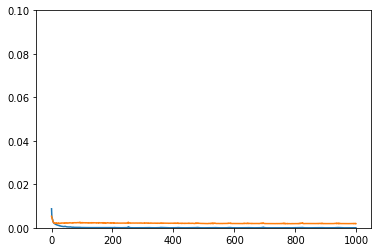

In [4]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.ylim(0,0.1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

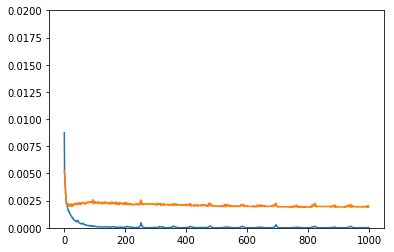

In [5]:
plt.ylim(0,0.02)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.38042261 0.38516462 0.4        0.4        0.39507534 0.4       ]
Predicted shape: [[0.39141488 0.3921369  0.40246916 0.3967588  0.40095663 0.40008363]]

Predicted shape: [[0.37902844 0.38508797 0.38934654 0.39758477 0.3913531  0.40807632]]



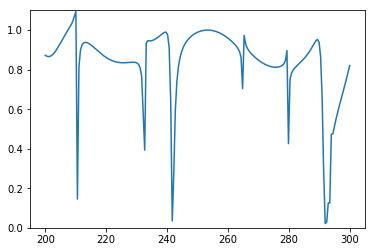

Test 1
True shape: [0.39507534 0.4        0.5        0.5        0.4        0.4       ]
Predicted shape: [[0.38970467 0.39919624 0.49529114 0.49899107 0.39315912 0.39531234]]

Predicted shape: [[0.38812065 0.3942927  0.5053988  0.49248543 0.41157204 0.39522842]]



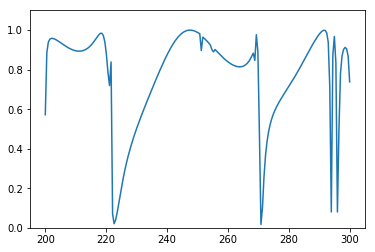

Test 2
True shape: [0.4        0.4389726  0.5        0.4        0.5        0.49384417]
Predicted shape: [[0.5006635  0.4549283  0.40414402 0.4194677  0.4854851  0.49763593]]

Predicted shape: [[0.4146249  0.44265395 0.49136487 0.4107681  0.49163866 0.5028426 ]]



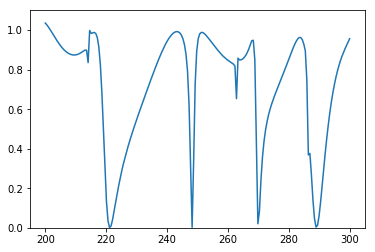

Test 3
True shape: [0.3        0.4        0.39015067 0.39015067 0.4        0.39507534]
Predicted shape: [[0.30502814 0.406281   0.3973403  0.39618945 0.39607358 0.38875094]]

Predicted shape: [[0.29029882 0.39843902 0.39852822 0.38326567 0.39923304 0.39647967]]



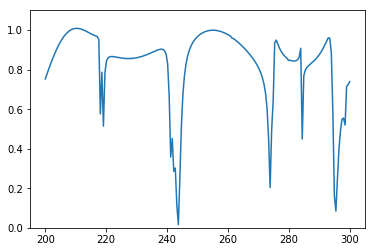

Test 4
True shape: [0.39507534 0.4        0.39507534 0.4        0.5        0.49384417]
Predicted shape: [[0.40661833 0.4052251  0.39945024 0.39932472 0.49818355 0.4856889 ]]

Predicted shape: [[0.3934565  0.3983033  0.39297247 0.39724416 0.49745336 0.49633884]]



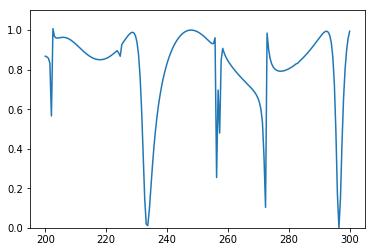

Test 5
True shape: [0.3        0.4        0.39507534 0.4        0.4        0.39507534]
Predicted shape: [[0.31469178 0.4006081  0.39737123 0.39896765 0.393828   0.40019792]]

Predicted shape: [[0.30992723 0.39708593 0.4027847  0.39005166 0.39838886 0.40571025]]



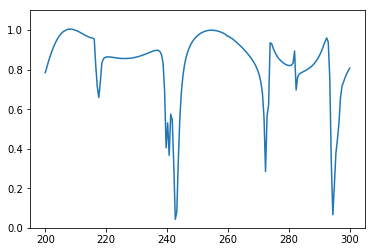

Test 6
True shape: [0.38042261 0.38516462 0.4        0.4        0.338636   0.3       ]
Predicted shape: [[0.36171773 0.3762778  0.38359696 0.3744411  0.38515952 0.38830572]]

Predicted shape: [[0.37566334 0.39251179 0.40519422 0.4121389  0.34898064 0.2817346 ]]



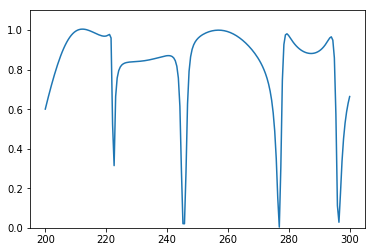

Test 7
True shape: [0.39507534 0.4        0.39015067 0.39015067 0.4        0.5       ]
Predicted shape: [[0.40208903 0.39392054 0.38467228 0.38674533 0.38870886 0.4695434 ]]

Predicted shape: [[0.40892196 0.3959971  0.3909707  0.38698798 0.38864073 0.48596093]]



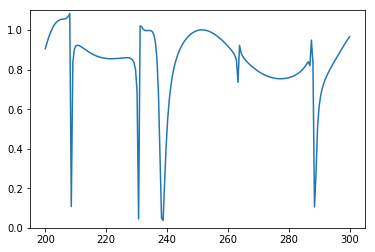

Test 8
True shape: [0.4        0.4        0.3        0.3        0.2        0.19753767]
Predicted shape: [[0.3933767  0.3993589  0.31185958 0.29718685 0.18601027 0.19488789]]

Predicted shape: [[0.40200657 0.39967042 0.30775177 0.301034   0.20375928 0.19393678]]



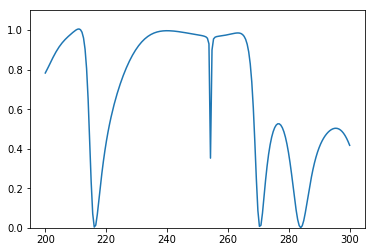

Test 9
True shape: [0.39507534 0.4        0.3        0.338636   0.4        0.39507534]
Predicted shape: [[0.39635342 0.40288153 0.34446186 0.31717625 0.37952358 0.39248645]]

Predicted shape: [[0.39495736 0.4049502  0.29489124 0.33083442 0.3989219  0.40517107]]



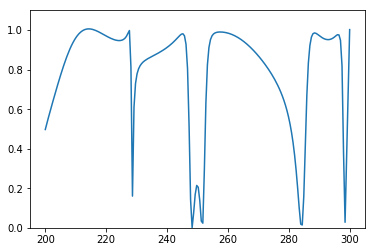

Test 10
True shape: [0.47552826 0.48145578 0.5        0.4        0.3        0.3       ]
Predicted shape: [[0.4581925  0.46835613 0.43382493 0.41507837 0.34619117 0.29261944]]

Predicted shape: [[0.47466886 0.47466615 0.49410418 0.4001382  0.2845732  0.3126477 ]]



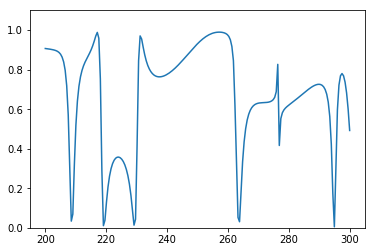

Test 11
True shape: [0.4        0.38516462 0.38042261 0.38516462 0.4        0.39507534]
Predicted shape: [[0.39291716 0.3903615  0.3980742  0.38636446 0.38343975 0.38932228]]

Predicted shape: [[0.40584642 0.39369476 0.3887325  0.3883255  0.3986114  0.40418157]]



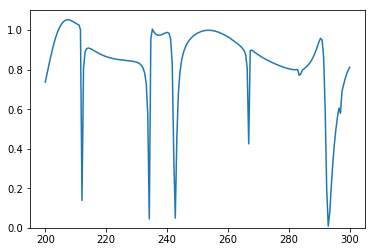

Test 12
True shape: [0.2        0.3        0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.3760721  0.33861032 0.29432172 0.25378758 0.3706285  0.48390985]]

Predicted shape: [[0.19889873 0.30155525 0.40579355 0.38956803 0.40559247 0.5147896 ]]



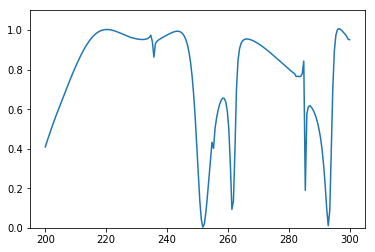

Test 13
True shape: [0.4        0.41826582 0.44988746 0.5        0.49384417 0.5       ]
Predicted shape: [[0.40132594 0.4257328  0.44432807 0.5017376  0.5045095  0.50139093]]

Predicted shape: [[0.39603585 0.40942752 0.4509523  0.49892402 0.48944378 0.5032207 ]]



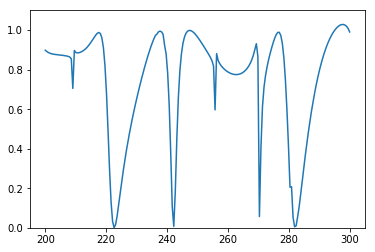

Test 14
True shape: [0.2       0.2370452 0.3       0.4       0.4       0.3      ]
Predicted shape: [[0.21879512 0.3069128  0.32613507 0.39769658 0.31143284 0.39452124]]

Predicted shape: [[0.21561691 0.21875086 0.29973605 0.3884282  0.409128   0.30425322]]



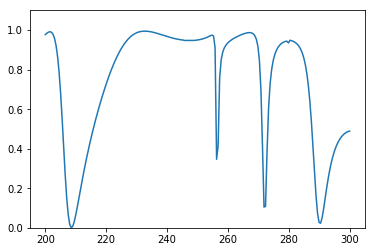

Test 15
True shape: [0.39507534 0.4        0.5        0.4        0.3        0.3       ]
Predicted shape: [[0.39302382 0.3967226  0.49883482 0.40033814 0.2946581  0.30111897]]

Predicted shape: [[0.39322713 0.39682615 0.5146124  0.39742512 0.30768067 0.2963334 ]]



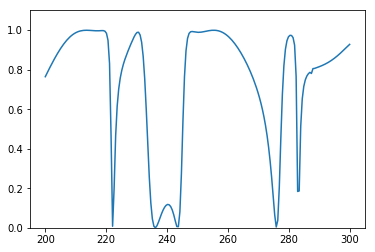

Test 16
True shape: [0.3 0.2 0.3 0.4 0.4 0.3]
Predicted shape: [[0.19315079 0.31005955 0.34590876 0.32805216 0.35199487 0.3481817 ]]

Predicted shape: [[0.29609758 0.19819963 0.31183183 0.38054883 0.40210727 0.30448312]]



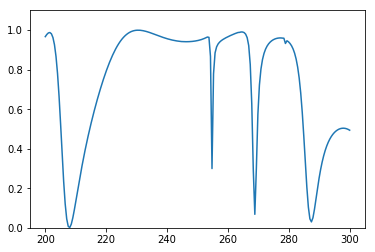

Test 17
True shape: [0.1      0.2      0.3      0.338636 0.4      0.4     ]
Predicted shape: [[0.10033464 0.19936365 0.2978794  0.3386947  0.3974118  0.38704574]]

Predicted shape: [[0.1016587  0.19258767 0.28286082 0.33695126 0.39938504 0.39055553]]



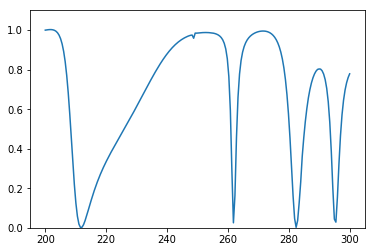

Test 18
True shape: [0.49384417 0.5        0.4389726  0.4        0.4        0.3       ]
Predicted shape: [[0.44367412 0.48706704 0.4484393  0.417566   0.3462352  0.33121923]]

Predicted shape: [[0.48862588 0.50030583 0.442368   0.39641684 0.39575318 0.3070033 ]]



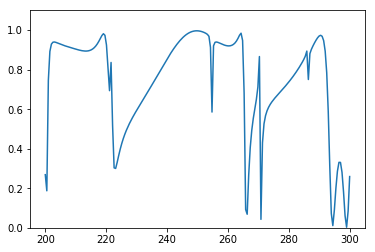

Test 19
True shape: [0.49384417 0.5        0.4        0.4        0.4389726  0.5       ]
Predicted shape: [[0.46577618 0.48460105 0.4180894  0.43037108 0.4138075  0.4629474 ]]

Predicted shape: [[0.49581963 0.49280092 0.3987139  0.40023077 0.4330707  0.51974505]]



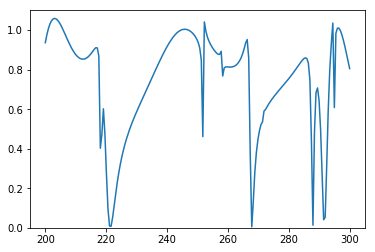

Test 20
True shape: [0.35640261 0.36084521 0.37474388 0.4        0.5        0.4       ]
Predicted shape: [[0.3989924  0.3988127  0.3869024  0.39140177 0.43595093 0.46897036]]

Predicted shape: [[0.37106574 0.39356452 0.41778192 0.37897626 0.41532153 0.5121553 ]]



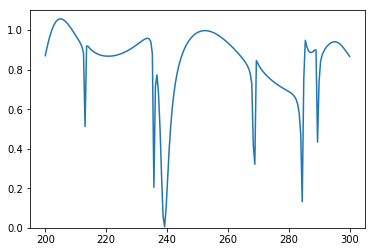

Test 21
True shape: [0.2963065  0.3        0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.29228088 0.3166554  0.4042519  0.5073307  0.49175128 0.4945466 ]]

Predicted shape: [[0.2986728  0.29994205 0.40548152 0.49137527 0.5010819  0.50171405]]



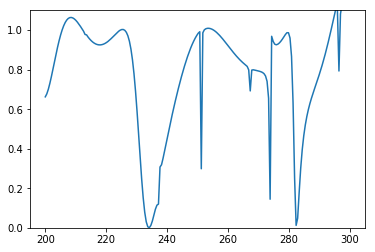

Test 22
True shape: [0.4       0.5       0.4389726 0.4       0.5       0.4      ]
Predicted shape: [[0.47487575 0.45313343 0.4414602  0.43998235 0.42612612 0.49593964]]

Predicted shape: [[0.38129693 0.49922925 0.4390071  0.4076236  0.48962626 0.40180832]]



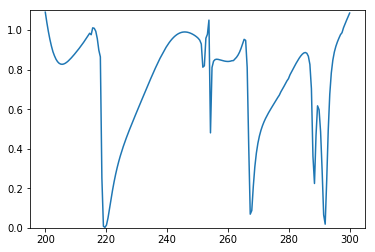

Test 23
True shape: [0.4 0.5 0.4 0.3 0.2 0.2]
Predicted shape: [[0.39898178 0.47659326 0.41690245 0.31895164 0.23983936 0.20231034]]

Predicted shape: [[0.39299792 0.4974697  0.407058   0.2866792  0.22175175 0.2045702 ]]



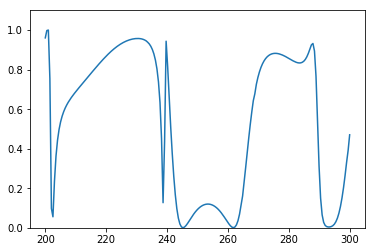

Test 24
True shape: [0.5       0.4       0.4       0.338636  0.3       0.2963065]
Predicted shape: [[0.41212997 0.4007935  0.42470455 0.36368364 0.36320627 0.33670765]]

Predicted shape: [[0.4991448  0.3913844  0.40048808 0.35111684 0.29836765 0.28874373]]



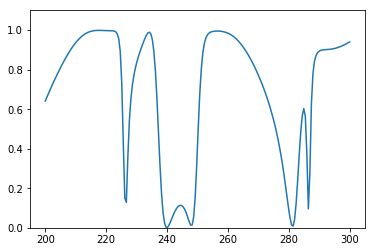

Test 25
True shape: [0.3        0.3        0.4        0.4389726  0.5        0.49384417]
Predicted shape: [[0.29936486 0.30305833 0.4000378  0.43611297 0.4899344  0.49682593]]

Predicted shape: [[0.29901695 0.3010379  0.39742637 0.433218   0.5000896  0.4998415 ]]



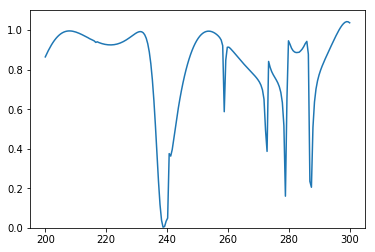

Test 26
True shape: [0.28531695 0.28887347 0.3        0.4        0.4389726  0.5       ]
Predicted shape: [[0.41641337 0.37685716 0.35788858 0.3222614  0.40417388 0.4621711 ]]

Predicted shape: [[0.29086623 0.27682227 0.2997467  0.39516157 0.4445331  0.5054242 ]]



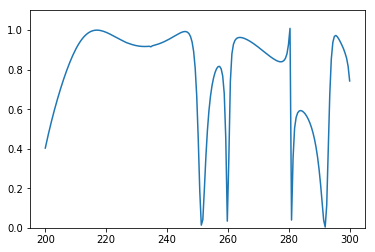

Test 27
True shape: [0.2        0.2370452  0.3        0.3        0.4        0.39507534]
Predicted shape: [[0.20386872 0.25077552 0.2960837  0.31417716 0.41232762 0.33239   ]]

Predicted shape: [[0.19943845 0.23700488 0.2960718  0.30152863 0.38275608 0.39691928]]



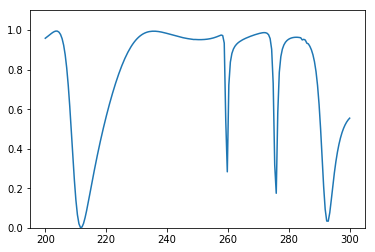

Test 28
True shape: [0.4       0.4       0.4       0.338636  0.3       0.2963065]
Predicted shape: [[0.38944852 0.3618338  0.34562755 0.3470548  0.29397252 0.3759396 ]]

Predicted shape: [[0.38494208 0.40566662 0.40112728 0.34703928 0.29759958 0.29236767]]



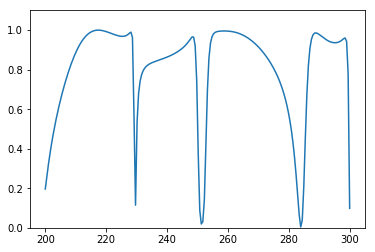

Test 29
True shape: [0.1 0.2 0.3 0.4 0.4 0.5]
Predicted shape: [[0.2003502  0.2921099  0.37548795 0.42545527 0.3937121  0.42916775]]

Predicted shape: [[0.10280934 0.19859132 0.3007607  0.39445567 0.40954193 0.5305396 ]]



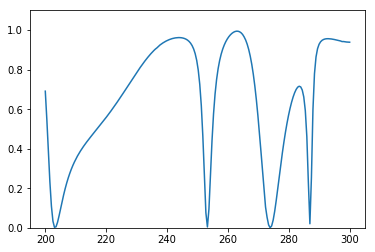

Test 30
True shape: [0.5       0.4       0.4       0.4389726 0.5       0.5      ]
Predicted shape: [[0.41786766 0.39810508 0.48512468 0.42461333 0.49333256 0.4840074 ]]

Predicted shape: [[0.49292484 0.39667156 0.4115833  0.44195262 0.50006866 0.50438637]]



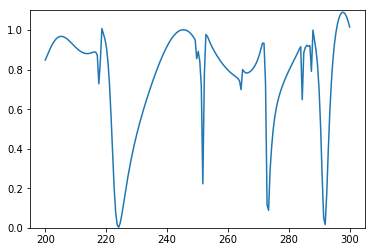

Test 31
True shape: [0.4 0.4 0.3 0.4 0.4 0.4]
Predicted shape: [[0.40253514 0.3967709  0.3125763  0.39533737 0.4028804  0.40035608]]

Predicted shape: [[0.4072845  0.4020769  0.3043647  0.39445108 0.3985629  0.40396976]]



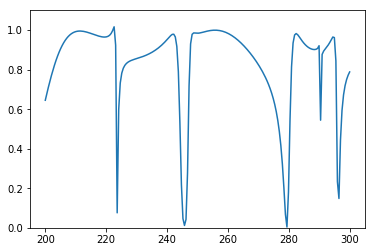

Test 32
True shape: [0.4        0.39507534 0.4        0.3        0.3        0.2       ]
Predicted shape: [[0.39371952 0.3915553  0.36960104 0.28629357 0.284146   0.19931838]]

Predicted shape: [[0.39947295 0.39517397 0.37968865 0.2964335  0.29140422 0.21703883]]



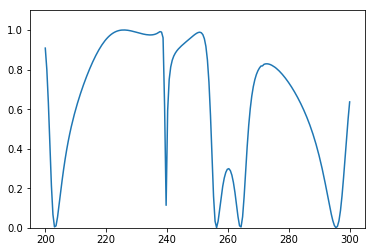

Test 33
True shape: [0.19753767 0.2        0.3        0.4        0.38516462 0.38042261]
Predicted shape: [[0.20324022 0.20030004 0.30377662 0.39843777 0.38064456 0.3797274 ]]

Predicted shape: [[0.20123279 0.19437656 0.2921778  0.3987128  0.39442763 0.385585  ]]



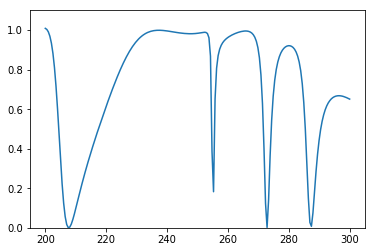

Test 34
True shape: [0.4 0.4 0.4 0.3 0.4 0.3]
Predicted shape: [[0.40289384 0.40581113 0.3914124  0.3527577  0.35551488 0.32342756]]

Predicted shape: [[0.4057127  0.3975985  0.3797617  0.32865497 0.393859   0.30520442]]



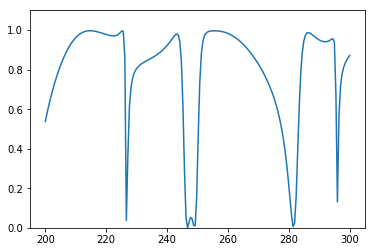

Test 35
True shape: [0.1        0.2        0.3        0.4        0.38516462 0.38042261]
Predicted shape: [[0.16271666 0.21392399 0.32345325 0.38759607 0.40824053 0.37578043]]

Predicted shape: [[0.09817719 0.16777441 0.2537994  0.3523898  0.3823315  0.36422515]]



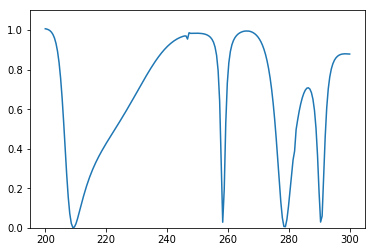

Test 36
True shape: [0.5 0.4 0.5 0.4 0.5 0.4]
Predicted shape: [[0.49123    0.4041498  0.50243664 0.43880856 0.38206735 0.49020857]]

Predicted shape: [[0.49876812 0.38118577 0.51418614 0.39463118 0.48093215 0.3971795 ]]



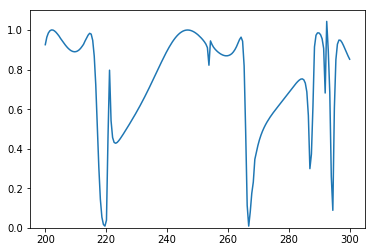

Test 37
True shape: [0.38042261 0.38516462 0.4        0.4        0.4        0.5       ]
Predicted shape: [[0.38637212 0.38749355 0.40117332 0.4062351  0.4139193  0.40828264]]

Predicted shape: [[0.38601217 0.40358815 0.38350046 0.38506606 0.40526506 0.49322182]]



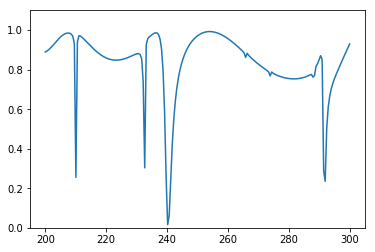

Test 38
True shape: [0.49384417 0.5        0.4        0.3        0.2        0.1       ]
Predicted shape: [[0.44766015 0.39713103 0.42806333 0.3535759  0.23859066 0.20086059]]

Predicted shape: [[0.4919232  0.4972736  0.3792225  0.27656686 0.19301079 0.10208336]]



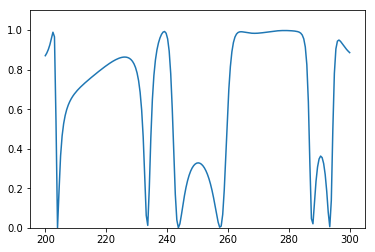

Test 39
True shape: [0.4 0.4 0.5 0.4 0.4 0.3]
Predicted shape: [[0.41036624 0.3884559  0.38933846 0.4103235  0.40687227 0.31706527]]

Predicted shape: [[0.40844    0.391248   0.48931018 0.39944077 0.3858713  0.30133465]]



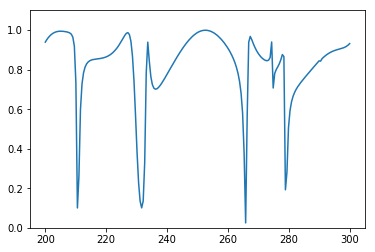

Test 40
True shape: [0.2       0.2370452 0.3       0.3       0.4       0.5      ]
Predicted shape: [[0.26480612 0.25900695 0.28316176 0.3550725  0.40137663 0.48027247]]

Predicted shape: [[0.1938914  0.25258392 0.31876445 0.31305957 0.42149174 0.48881528]]



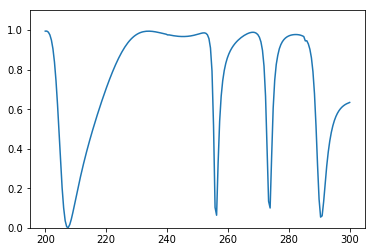

Test 41
True shape: [0.5        0.4        0.38516462 0.38042261 0.38516462 0.4       ]
Predicted shape: [[0.36119634 0.37273878 0.36645204 0.3807286  0.3906972  0.340658  ]]

Predicted shape: [[0.5029619  0.40848705 0.38048053 0.37164563 0.38078097 0.40750715]]



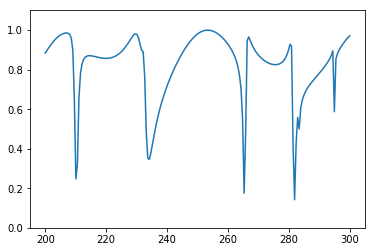

Test 42
True shape: [0.4        0.4        0.4        0.39507534 0.4        0.39507534]
Predicted shape: [[0.39901674 0.40658742 0.39255893 0.3990988  0.38521    0.40778702]]

Predicted shape: [[0.39224786 0.4044957  0.40051937 0.39309338 0.39671692 0.39892524]]



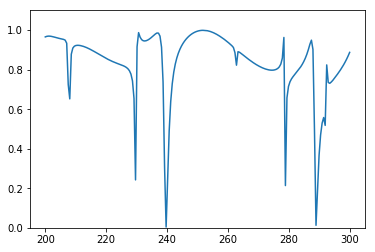

Test 43
True shape: [0.4       0.5       0.4389726 0.4       0.3       0.4      ]
Predicted shape: [[0.44590536 0.50153846 0.46256924 0.40927434 0.29986835 0.27360132]]

Predicted shape: [[0.45137325 0.46408215 0.47211492 0.38770735 0.35510826 0.31734234]]



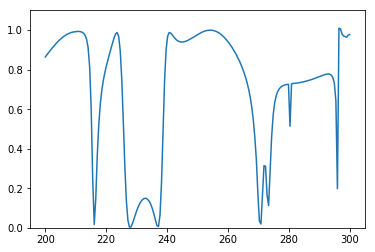

Test 44
True shape: [0.4 0.4 0.4 0.4 0.3 0.4]
Predicted shape: [[0.37529844 0.4034438  0.40417582 0.3918312  0.409612   0.36986345]]

Predicted shape: [[0.37521082 0.40428486 0.38833693 0.401159   0.29782486 0.4075767 ]]



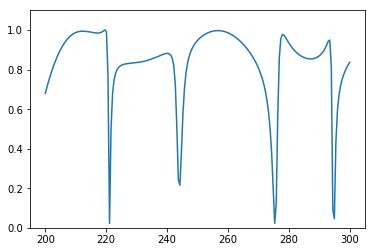

Test 45
True shape: [0.2963065 0.3       0.4       0.5       0.4       0.5      ]
Predicted shape: [[0.33588183 0.32723486 0.42534146 0.42435902 0.43121934 0.37155983]]

Predicted shape: [[0.29471537 0.2983206  0.39948514 0.5028252  0.4068665  0.5041539 ]]



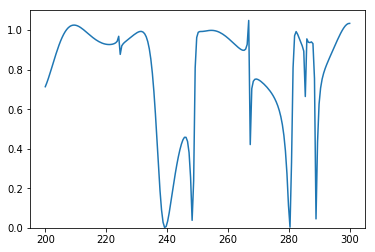

Test 46
True shape: [0.4        0.39015067 0.39015067 0.4        0.5        0.49384417]
Predicted shape: [[0.35870507 0.376435   0.41002652 0.43798375 0.4690889  0.4250233 ]]

Predicted shape: [[0.4000734  0.38624862 0.3956222  0.39954352 0.5023942  0.49193943]]



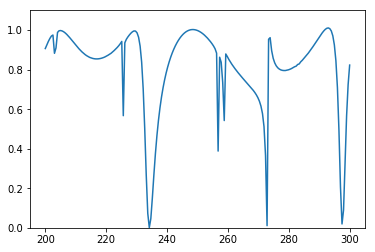

Test 47
True shape: [0.4        0.3        0.4        0.4        0.4        0.39507534]
Predicted shape: [[0.3891258  0.32518035 0.38788635 0.41575155 0.39603794 0.39323777]]

Predicted shape: [[0.39920697 0.2973344  0.40586108 0.40594617 0.40019083 0.4061895 ]]



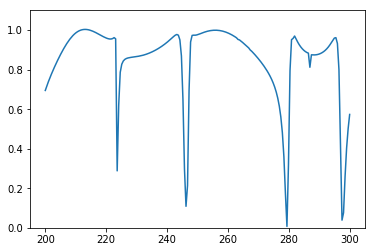

Test 48
True shape: [0.49384417 0.5        0.4        0.338636   0.3        0.2963065 ]
Predicted shape: [[0.44701385 0.46565834 0.40243888 0.3039104  0.39833444 0.3674109 ]]

Predicted shape: [[0.4917401  0.500022   0.41639274 0.342005   0.31099948 0.28196302]]



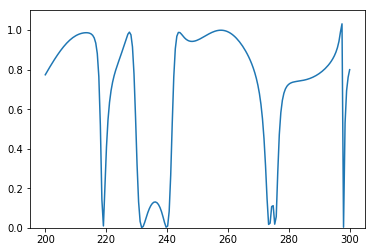

Test 49
True shape: [0.4        0.4389726  0.5        0.46842985 0.45105652 0.44550326]
Predicted shape: [[0.4208935  0.45914653 0.4035351  0.46903095 0.4820958  0.51515776]]

Predicted shape: [[0.43267122 0.443868   0.48226136 0.42132154 0.5262991  0.49534574]]



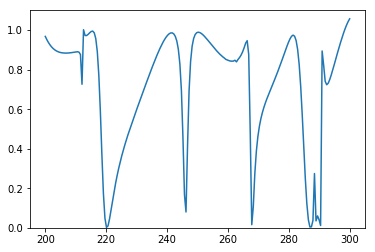

Test 50
True shape: [0.4 0.4 0.4 0.5 0.5 0.5]
Predicted shape: [[0.4093797  0.39602992 0.42271528 0.49878794 0.48872882 0.45979553]]

Predicted shape: [[0.38023895 0.39605471 0.40764368 0.49734342 0.4856502  0.5086579 ]]



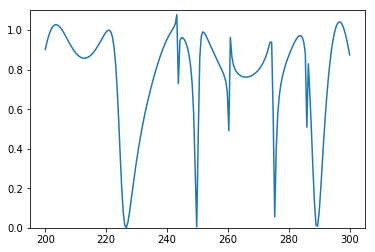

Test 51
True shape: [0.49384417 0.5        0.4        0.338636   0.3        0.3       ]
Predicted shape: [[0.44989184 0.46335143 0.40491244 0.30330116 0.39991206 0.37180716]]

Predicted shape: [[0.48914    0.49970806 0.41363633 0.3448341  0.31277207 0.28394184]]



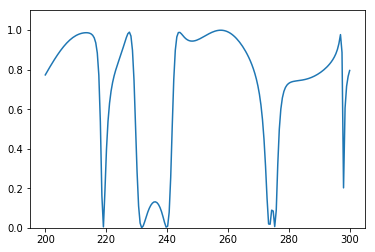

Test 52
True shape: [0.49384417 0.5        0.4        0.5        0.4389726  0.4       ]
Predicted shape: [[0.46633744 0.43277696 0.44640934 0.43082592 0.4943512  0.5362006 ]]

Predicted shape: [[0.48889887 0.49504548 0.41348997 0.50492734 0.44259652 0.40683708]]



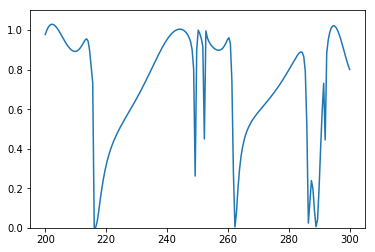

Test 53
True shape: [0.5       0.5       0.4       0.4       0.3       0.2963065]
Predicted shape: [[0.4644108  0.45438185 0.4391836  0.3946737  0.30134627 0.310524  ]]

Predicted shape: [[0.4685771  0.46497494 0.4646654  0.3980472  0.31291386 0.35794213]]



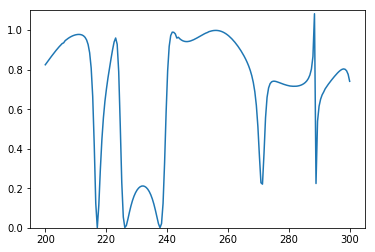

Test 54
True shape: [0.38042261 0.38516462 0.4        0.35084526 0.31945452 0.3       ]
Predicted shape: [[0.40493417 0.393282   0.37006062 0.36056912 0.33328566 0.32298988]]

Predicted shape: [[0.4074311  0.394113   0.37187496 0.34565204 0.36742625 0.3235235 ]]



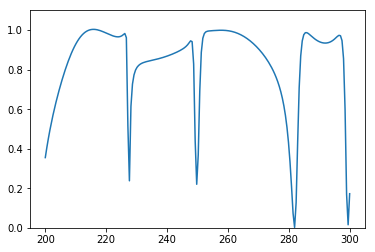

Test 55
True shape: [0.39507534 0.4        0.3        0.4        0.4        0.4       ]
Predicted shape: [[0.39992586 0.39735377 0.30384007 0.4022908  0.4002455  0.39636806]]

Predicted shape: [[0.4089974  0.39945978 0.29908055 0.39902914 0.39593303 0.40180364]]



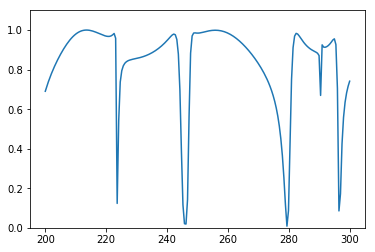

Test 56
True shape: [0.4      0.4      0.4      0.338636 0.3      0.4     ]
Predicted shape: [[0.39660424 0.3967568  0.3833379  0.35912287 0.35333237 0.34284282]]

Predicted shape: [[0.41526607 0.39722222 0.3956737  0.3459345  0.29997703 0.42615393]]



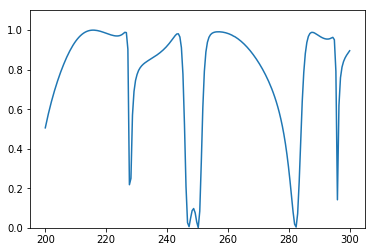

Test 57
True shape: [0.4        0.4        0.39507534 0.4        0.5        0.5       ]
Predicted shape: [[0.40606314 0.40319726 0.3973839  0.40323302 0.5002531  0.49662122]]

Predicted shape: [[0.39871976 0.40091613 0.40668768 0.39325595 0.49160016 0.49938208]]



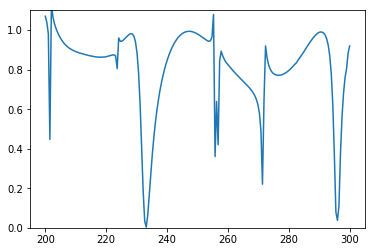

Test 58
True shape: [0.2 0.3 0.4 0.4 0.4 0.5]
Predicted shape: [[0.37614167 0.34033167 0.29120857 0.25439942 0.3582835  0.46164298]]

Predicted shape: [[0.2043947  0.29915547 0.39398545 0.39443213 0.41584778 0.51880854]]



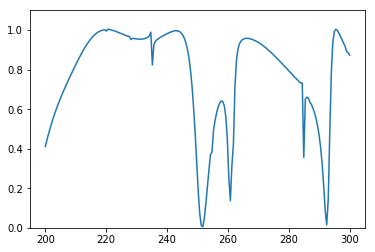

Test 59
True shape: [0.4 0.5 0.5 0.4 0.3 0.2]
Predicted shape: [[0.48478666 0.48019323 0.39337024 0.35676044 0.36073744 0.30202952]]

Predicted shape: [[0.39259034 0.5219934  0.4675949  0.40833336 0.2851559  0.20795949]]



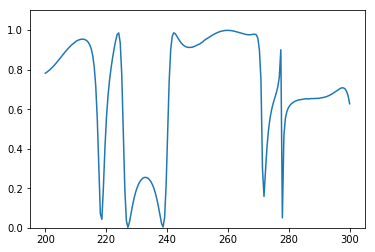

Test 60
True shape: [0.4 0.4 0.5 0.5 0.4 0.3]
Predicted shape: [[0.3909212  0.3936753  0.50920796 0.48587838 0.39464247 0.33719403]]

Predicted shape: [[0.38802665 0.40108058 0.51424444 0.49478605 0.40223932 0.29516146]]



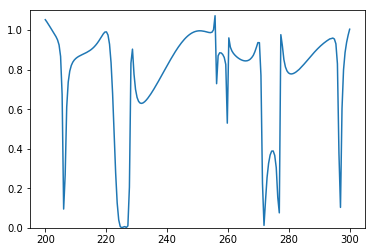

Test 61
True shape: [0.39507534 0.4        0.4        0.338636   0.3        0.4       ]
Predicted shape: [[0.39154398 0.39233136 0.39013606 0.32115808 0.3403593  0.40884092]]

Predicted shape: [[0.40860116 0.39381778 0.39854276 0.34232607 0.31351066 0.4166329 ]]



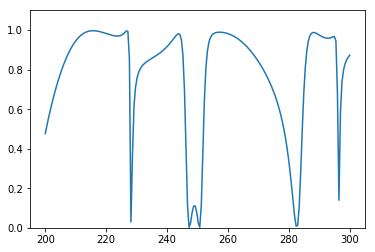

Test 62
True shape: [0.4      0.4      0.338636 0.3      0.338636 0.4     ]
Predicted shape: [[0.3822447  0.37680477 0.38663328 0.3536762  0.31559023 0.35423267]]

Predicted shape: [[0.40977284 0.40276527 0.35111892 0.30536127 0.35571203 0.41418165]]



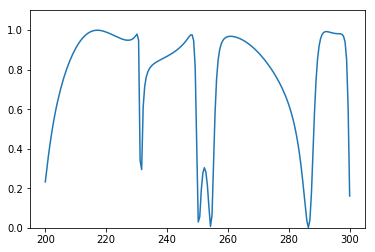

Test 63
True shape: [0.39507534 0.4        0.3        0.3        0.2        0.2       ]
Predicted shape: [[0.39374048 0.398762   0.3002752  0.30613726 0.18916148 0.19572555]]

Predicted shape: [[0.40045884 0.39710385 0.30335593 0.3003832  0.20643373 0.19741313]]



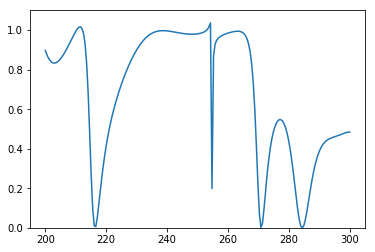

Test 64
True shape: [0.4        0.41826582 0.44988746 0.5        0.4389726  0.4       ]
Predicted shape: [[0.42890787 0.42380846 0.40831017 0.45952216 0.49524522 0.47396812]]

Predicted shape: [[0.39920416 0.4123823  0.44831434 0.5081352  0.4297385  0.38668412]]



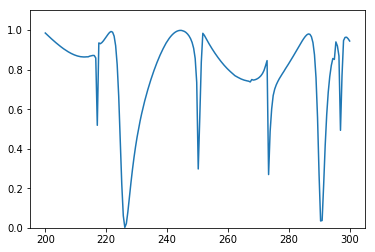

Test 65
True shape: [0.39507534 0.4        0.4        0.3        0.3        0.2       ]
Predicted shape: [[0.39067554 0.3940328  0.36586735 0.2829236  0.2780243  0.19871487]]

Predicted shape: [[0.39976168 0.39949352 0.37415406 0.2999217  0.274374   0.20209517]]



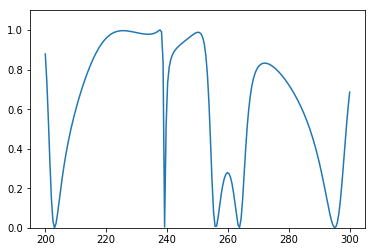

Test 66
True shape: [0.4      0.4      0.338636 0.3      0.4      0.4     ]
Predicted shape: [[0.40041298 0.39815313 0.33551782 0.31025392 0.4032504  0.38886052]]

Predicted shape: [[0.39323008 0.40339372 0.3442092  0.30942613 0.40480605 0.41606414]]



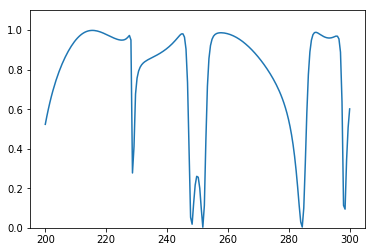

Test 67
True shape: [0.39507534 0.4        0.39507534 0.4        0.3        0.2963065 ]
Predicted shape: [[0.396485   0.4002838  0.39521968 0.39871866 0.30363762 0.3021348 ]]

Predicted shape: [[0.38717353 0.39227834 0.39675403 0.41191965 0.28897506 0.29347947]]



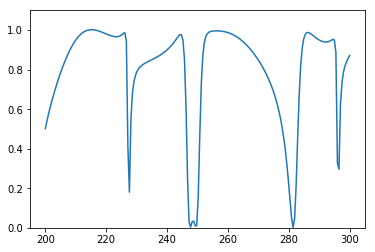

Test 68
True shape: [0.49384417 0.5        0.4        0.3        0.338636   0.4       ]
Predicted shape: [[0.42316017 0.51037455 0.42938966 0.37376863 0.33876723 0.29712376]]

Predicted shape: [[0.50477827 0.48832744 0.41586903 0.30782598 0.338789   0.39775142]]



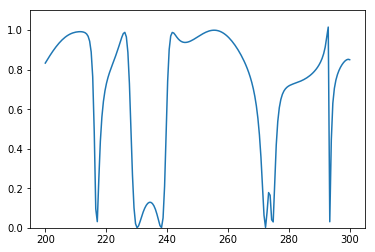

Test 69
True shape: [0.4        0.39507534 0.4        0.39507534 0.4        0.5       ]
Predicted shape: [[0.39525902 0.3990297  0.38048226 0.38778466 0.3900891  0.45471826]]

Predicted shape: [[0.39608374 0.39686358 0.39631784 0.3917017  0.39638314 0.49721608]]



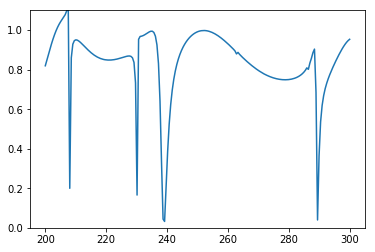

Test 70
True shape: [0.5        0.4        0.39507534 0.4        0.3        0.3       ]
Predicted shape: [[0.46102235 0.41910428 0.38046485 0.3663317  0.34784952 0.32351184]]

Predicted shape: [[0.48811308 0.39608943 0.38882697 0.3947432  0.28733727 0.30570552]]



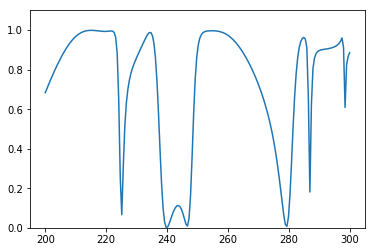

Test 71
True shape: [0.4 0.5 0.5 0.4 0.3 0.4]
Predicted shape: [[0.41632822 0.40567985 0.4851673  0.42130944 0.38982996 0.42726812]]

Predicted shape: [[0.381595   0.49679768 0.50133115 0.40602648 0.30745298 0.3961255 ]]



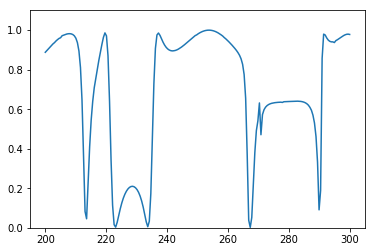

Test 72
True shape: [0.49384417 0.5        0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.44382483 0.44690356 0.40476313 0.4141538  0.46179742 0.52343136]]

Predicted shape: [[0.48633382 0.4975258  0.39523956 0.49655348 0.4956338  0.49012828]]



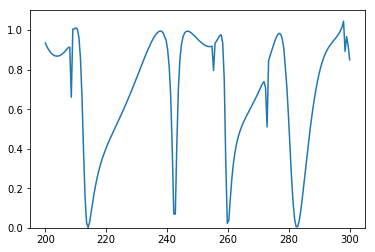

Test 73
True shape: [0.3       0.4       0.4389726 0.5       0.4       0.3      ]
Predicted shape: [[0.4723334  0.3496707  0.3787365  0.395744   0.36325568 0.41780388]]

Predicted shape: [[0.2925803  0.39267313 0.45838168 0.48451027 0.40063113 0.3087104 ]]



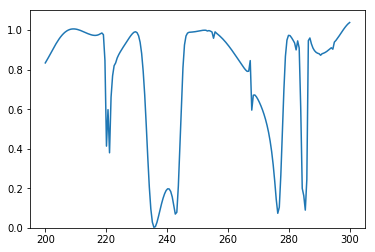

Test 74
True shape: [0.5        0.49384417 0.5        0.49384417 0.5        0.5       ]
Predicted shape: [[0.49049658 0.42212692 0.4616092  0.4852551  0.6308814  0.5588893 ]]

Predicted shape: [[0.497086   0.48379624 0.4878598  0.4838023  0.48618507 0.5026921 ]]



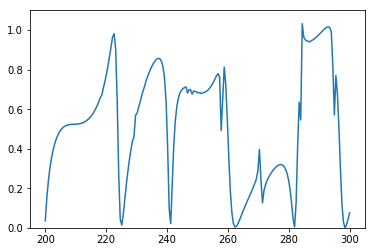

Test 75
True shape: [0.5        0.44988746 0.41826582 0.4        0.3        0.2       ]
Predicted shape: [[0.48583367 0.4902254  0.39551735 0.3447403  0.3083442  0.30860874]]

Predicted shape: [[0.5017469  0.44295982 0.40693104 0.40242752 0.30238065 0.18704991]]



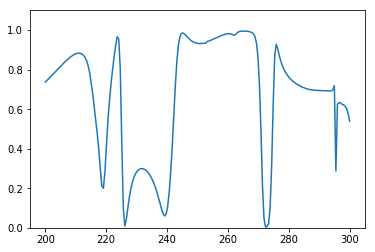

Test 76
True shape: [0.4        0.5        0.4        0.5        0.48145578 0.47552826]
Predicted shape: [[0.4868723  0.43067104 0.4253795  0.45939937 0.50836295 0.5351527 ]]

Predicted shape: [[0.40197006 0.5039848  0.40497413 0.49757865 0.48752075 0.47559127]]



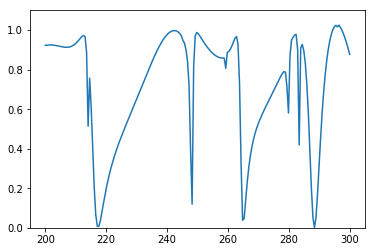

Test 77
True shape: [0.4       0.4       0.5       0.4389726 0.4       0.4      ]
Predicted shape: [[0.37949437 0.39620167 0.4912846  0.46935493 0.38612607 0.3892364 ]]

Predicted shape: [[0.3960191  0.39526647 0.51323515 0.4425192  0.39224795 0.40173325]]



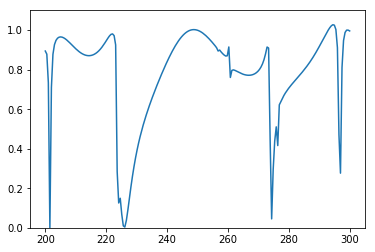

Test 78
True shape: [0.5 0.4 0.3 0.4 0.3 0.2]
Predicted shape: [[0.5060589  0.39980325 0.3114527  0.40031475 0.2789182  0.35265693]]

Predicted shape: [[0.48537815 0.3944785  0.2995029  0.3940124  0.30690503 0.18605168]]



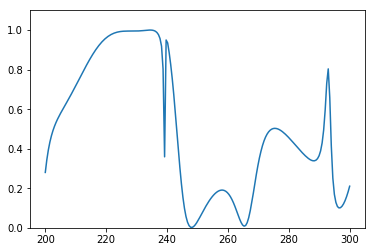

Test 79
True shape: [0.5       0.4       0.4       0.4       0.3       0.2963065]
Predicted shape: [[0.504159   0.40685007 0.39705753 0.32298917 0.36580116 0.30169553]]

Predicted shape: [[0.4962982  0.3965061  0.38303992 0.39462292 0.28836805 0.29922664]]



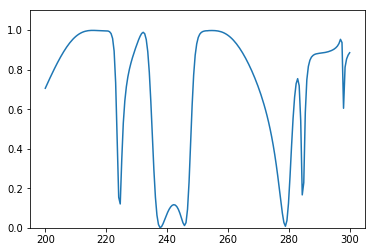

Test 80
True shape: [0.4 0.5 0.4 0.4 0.3 0.4]
Predicted shape: [[0.41738287 0.47772133 0.43852508 0.38320068 0.29780912 0.28147697]]

Predicted shape: [[0.3526097  0.45173147 0.44822878 0.41321462 0.24811141 0.27954325]]



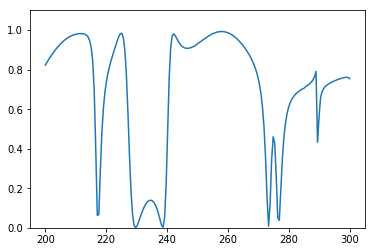

Test 81
True shape: [0.4      0.3      0.4      0.338636 0.3      0.4     ]
Predicted shape: [[0.3786461  0.32846254 0.38545835 0.42450672 0.2826259  0.28838295]]

Predicted shape: [[0.38868737 0.33028114 0.37109417 0.33669022 0.29493317 0.41520485]]



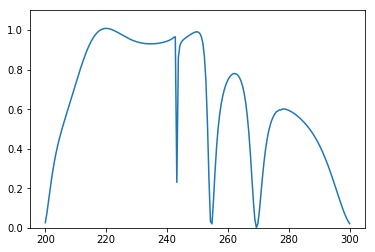

Test 82
True shape: [0.39507534 0.4        0.338636   0.3        0.4        0.4       ]
Predicted shape: [[0.39824757 0.3974868  0.33477336 0.3079152  0.40193373 0.38883954]]

Predicted shape: [[0.3906301  0.3963007  0.34006056 0.30062684 0.41014898 0.4061223 ]]



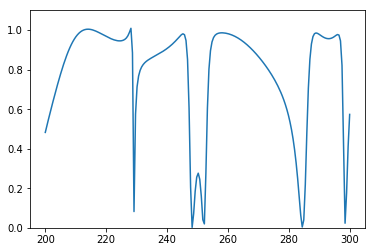

Test 83
True shape: [0.4        0.40597245 0.42269179 0.45246718 0.5        0.5       ]
Predicted shape: [[0.28707218 0.35608548 0.39762717 0.44795817 0.4301501  0.35814786]]

Predicted shape: [[0.4045087  0.40303463 0.4262495  0.44109562 0.5019059  0.5140517 ]]



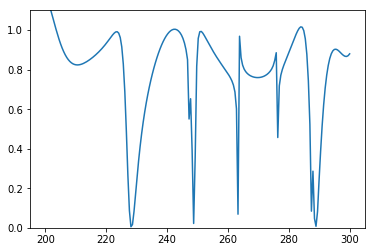

Test 84
True shape: [0.4        0.41826582 0.44988746 0.5        0.5        0.49384417]
Predicted shape: [[0.3828499  0.39923364 0.44518313 0.50461584 0.48879808 0.5074143 ]]

Predicted shape: [[0.39501816 0.3998402  0.45868042 0.4965058  0.49857676 0.49252298]]



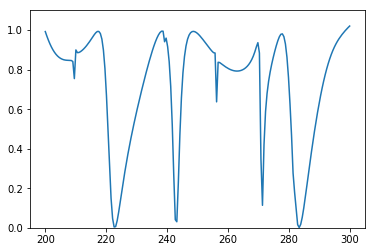

Test 85
True shape: [0.5      0.4      0.338636 0.3      0.338636 0.4     ]
Predicted shape: [[0.4885461  0.39751056 0.32633305 0.34332848 0.36154115 0.42326677]]

Predicted shape: [[0.50615895 0.4111387  0.34399867 0.3008486  0.3225427  0.4003149 ]]



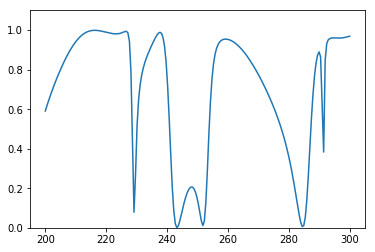

Test 86
True shape: [0.19753767 0.2        0.3        0.4        0.4        0.5       ]
Predicted shape: [[0.22697264 0.24181223 0.31428787 0.366629   0.39436027 0.46984223]]

Predicted shape: [[0.20678106 0.20669243 0.30685133 0.3844529  0.41278458 0.50489527]]



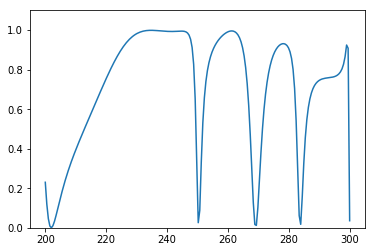

Test 87
True shape: [0.4      0.4      0.5      0.4      0.338636 0.3     ]
Predicted shape: [[0.3720926  0.4052348  0.46490183 0.4232725  0.39765573 0.40660667]]

Predicted shape: [[0.4066949  0.40006977 0.5056423  0.41314733 0.3666358  0.30168885]]



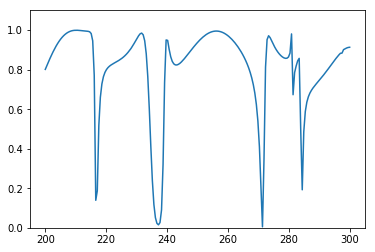

Test 88
True shape: [0.3      0.4      0.4      0.338636 0.3      0.4     ]
Predicted shape: [[0.34542316 0.39519072 0.3940278  0.39282203 0.28492698 0.32836273]]

Predicted shape: [[0.31501958 0.40116102 0.3953114  0.34678954 0.30665088 0.43529972]]



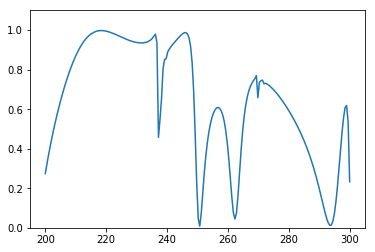

Test 89
True shape: [0.2 0.2 0.3 0.4 0.4 0.5]
Predicted shape: [[0.21544993 0.249226   0.31394106 0.36421213 0.3914453  0.47714087]]

Predicted shape: [[0.2051737  0.20366135 0.30248475 0.38474458 0.4136959  0.5097693 ]]



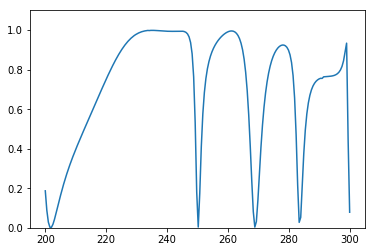

Test 90
True shape: [0.38042261 0.38516462 0.4        0.4        0.3        0.2963065 ]
Predicted shape: [[0.39219207 0.3943862  0.35515362 0.36716354 0.33428678 0.3501223 ]]

Predicted shape: [[0.38454565 0.3910026  0.40369344 0.4014924  0.2960731  0.29088745]]



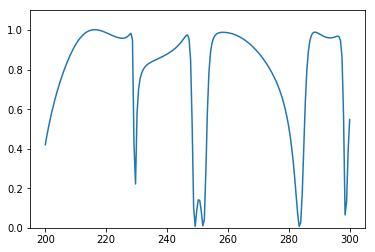

Test 91
True shape: [0.5        0.4        0.5        0.5        0.4        0.39507534]
Predicted shape: [[0.5021031  0.40621418 0.5021865  0.49848098 0.38801092 0.39374733]]

Predicted shape: [[0.501702   0.39291742 0.49752232 0.48520494 0.38728118 0.39482793]]



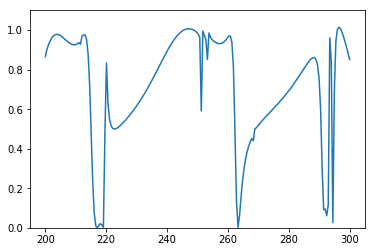

Test 92
True shape: [0.4       0.4389726 0.5       0.4       0.5       0.5      ]
Predicted shape: [[0.50137043 0.4597283  0.40526018 0.4281549  0.48078158 0.5074988 ]]

Predicted shape: [[0.4002802  0.43588883 0.4905983  0.41451943 0.49559316 0.49437603]]



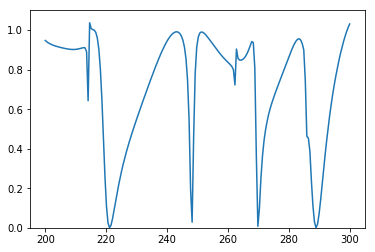

Test 93
True shape: [0.39507534 0.4        0.4389726  0.5        0.4        0.3       ]
Predicted shape: [[0.38226634 0.41813868 0.4010015  0.43992504 0.43366206 0.3442952 ]]

Predicted shape: [[0.39875758 0.39777395 0.44561318 0.5116578  0.39852098 0.29683086]]



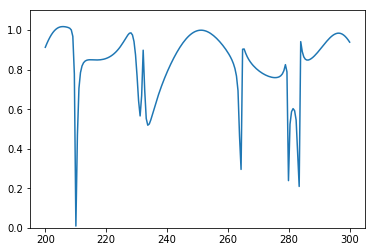

Test 94
True shape: [0.4        0.4        0.39507534 0.4        0.5        0.49384417]
Predicted shape: [[0.40629524 0.4030232  0.398242   0.407354   0.50023824 0.48827276]]

Predicted shape: [[0.40132153 0.40136552 0.4020985  0.39233643 0.49651754 0.49782085]]



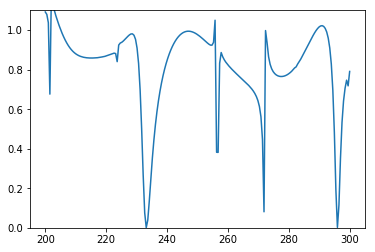

Test 95
True shape: [0.4       0.4       0.4389726 0.5       0.4       0.3      ]
Predicted shape: [[0.35304666 0.3832723  0.37680498 0.39857647 0.41717017 0.33958718]]

Predicted shape: [[0.39822903 0.400234   0.44772983 0.5121192  0.40324688 0.3125424 ]]



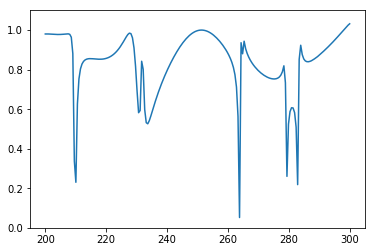

Test 96
True shape: [0.4        0.4        0.4        0.5        0.48145578 0.47552826]
Predicted shape: [[0.3964715  0.4121528  0.39904445 0.4849061  0.49649954 0.4919986 ]]

Predicted shape: [[0.387888   0.39341307 0.4017784  0.4955663  0.48796636 0.48303723]]



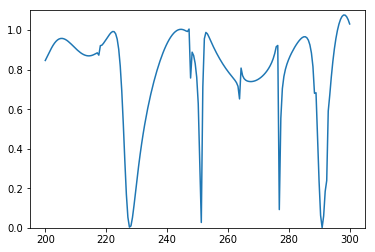

Test 97
True shape: [0.1      0.2      0.3      0.338636 0.4      0.5     ]
Predicted shape: [[0.1725792  0.22246355 0.33146852 0.37004638 0.40619636 0.4263469 ]]

Predicted shape: [[0.09099969 0.19733477 0.29627472 0.33684534 0.40887284 0.49662605]]



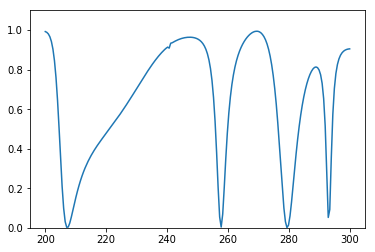

Test 98
True shape: [0.4        0.4        0.4        0.4389726  0.5        0.49384417]
Predicted shape: [[0.40068436 0.4060196  0.40062505 0.44335052 0.49816355 0.49372426]]

Predicted shape: [[0.39600816 0.40493566 0.40451714 0.44389418 0.50285023 0.503826  ]]



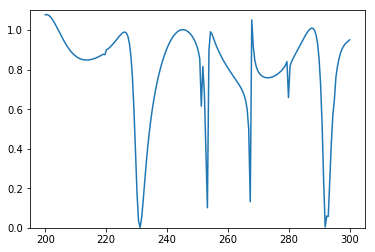

Test 99
True shape: [0.39507534 0.4        0.5        0.5        0.5        0.5       ]
Predicted shape: [[0.39709947 0.4050148  0.4978733  0.4932365  0.50133216 0.49445423]]

Predicted shape: [[0.39808124 0.38988626 0.5036069  0.49521595 0.49854845 0.50334936]]



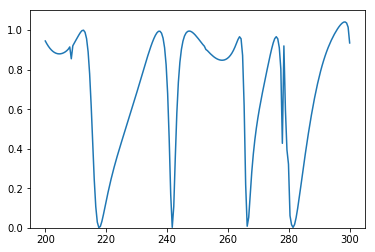

Test 100
True shape: [0.39507534 0.4        0.5        0.44988746 0.41826582 0.4       ]
Predicted shape: [[0.49013677 0.4105615  0.4106932  0.42151028 0.49233606 0.45450717]]

Predicted shape: [[0.39408487 0.40675065 0.50275946 0.44643572 0.4199796  0.399382  ]]



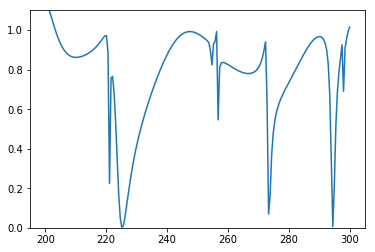

Test 101
True shape: [0.49384417 0.5        0.44988746 0.41826582 0.4        0.5       ]
Predicted shape: [[0.47207925 0.45157635 0.44758415 0.44848794 0.4827839  0.44523138]]

Predicted shape: [[0.4954297  0.4926603  0.45826396 0.41772807 0.40265194 0.5056248 ]]



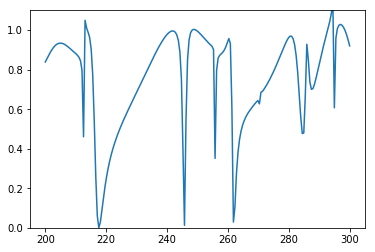

Test 102
True shape: [0.3        0.4        0.39507534 0.4        0.3        0.2       ]
Predicted shape: [[0.2927295  0.3851236  0.3893208  0.409365   0.2780538  0.19116986]]

Predicted shape: [[0.31075567 0.4021376  0.3831305  0.42655182 0.30033258 0.18292382]]



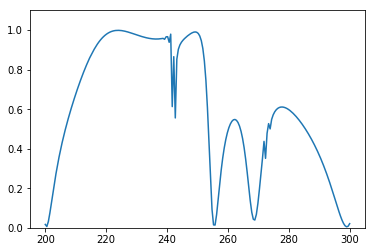

Test 103
True shape: [0.19753767 0.2        0.3        0.3        0.4        0.4       ]
Predicted shape: [[0.19439653 0.19594562 0.3024629  0.30333924 0.39556754 0.39332795]]

Predicted shape: [[0.20035955 0.19061056 0.2820565  0.30055195 0.3963211  0.39694867]]



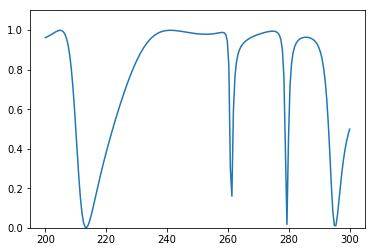

Test 104
True shape: [0.4        0.338636   0.3        0.28105791 0.27063391 0.26730196]
Predicted shape: [[0.4027688  0.34463567 0.31946483 0.31855112 0.30570048 0.24245532]]

Predicted shape: [[0.39974898 0.3377744  0.290834   0.27152032 0.27570197 0.26230872]]



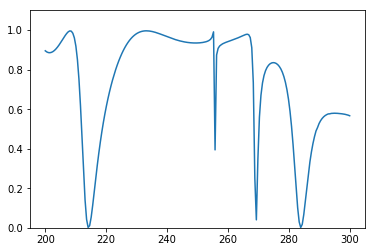

Test 105
True shape: [0.4 0.3 0.4 0.3 0.4 0.5]
Predicted shape: [[0.34615234 0.36204916 0.37539914 0.355627   0.44213337 0.42732856]]

Predicted shape: [[0.40549463 0.30001372 0.38758713 0.31248707 0.39873376 0.50921255]]



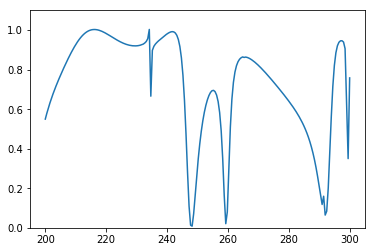

Test 106
True shape: [0.5      0.4      0.4      0.338636 0.3      0.3     ]
Predicted shape: [[0.39055046 0.40061226 0.439976   0.3750716  0.35761422 0.32178563]]

Predicted shape: [[0.5021962  0.39499167 0.40022457 0.34448844 0.3019941  0.29224887]]



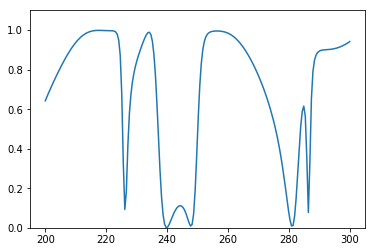

Test 107
True shape: [0.5        0.4        0.4        0.5        0.5        0.49384417]
Predicted shape: [[0.5006309  0.4034468  0.39349034 0.50610715 0.49923313 0.5037824 ]]

Predicted shape: [[0.4904705  0.4051508  0.40643322 0.48416692 0.49860582 0.49199757]]



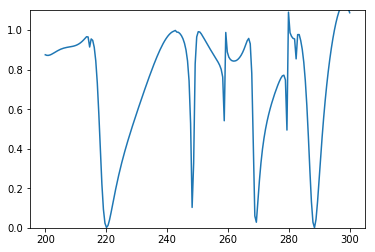

Test 108
True shape: [0.4 0.4 0.4 0.5 0.4 0.3]
Predicted shape: [[0.41671318 0.38601983 0.36845553 0.41701272 0.3897143  0.3144391 ]]

Predicted shape: [[0.41125903 0.40496704 0.400297   0.4946838  0.3930743  0.30059004]]



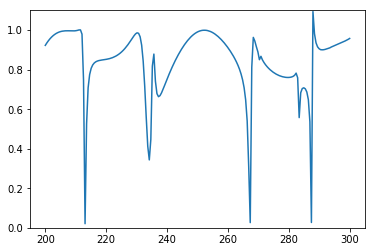

In [8]:
predicted = []
DFNN_all = load_model('DFNN_all')
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    print('Predicted shape: ' + str(DFNN_all.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))
    